# Text Analytics Coursework -- Tasks 1.1 to 1.3

# Instructions:

This notebook is forms the first part of your coursework assignment for Text Analytics in Spring 2025. You will need to read the instructions below and complete numbered tasks indicated by "TASK n". To complete the tasks, you will write code or explanations between the comments "#WRITE YOUR ANSWER HERE" and "#END OF ANSWER". For example:

TASK 0: Complete the function below to output "hello world". 


In [1]:
def demo_fun():
    # WRITE YOUR ANSWER HERE
    print("hello world")
    # END OF ANSWER

### DO NOT MODIFY
demo_fun()
###

hello world


There is also some code in the cell that should not be modified. This code saves your results to file in the correct format, which is necessary for us to be able to mark your answers. Before you submit your notebook, please make sure this code has not been modified, then restart your kernel, clear all cell outputs, run all of your code once again, then save the notebook. 

Please note:
  * The notebook you upload must include all the saved cell output after running all cells.
  * The notebook code must be complete so that it reproduces all your output when we run it. 
  * For this coursework, we recommend that you use your virtual environment that you created for the labs. The packages you need are: numpy, scipy, nltk, pytorch, transformers and datasets (from HuggingFace), pandas, matplotlib and scikit-learn. 

## Marking guidelines:
1. This notebook is worth 32% of the marks for the Text Analytics assignment.
1. The number of marks for each task is shown alongside the task.
1. We will evaluate the output of your code after running it, and marks will be awarded based on how well the output matches the task's instructions. 
1. We will give partial marks for incomplete or partially correct answers. 
1. We do not give additional marks for code style or comments, but clear code will help us to understand what you have done so that we can award partial marks where necessary. 
1. Unless the task asks you to implement something from scratch, there is no penalty for using software libraries in your implementation.

## Support:

The main source of support will be during the lab sessions. The TAs and lecturers will help you with questions about the lectures, the code provided for you in this notebook, and general questions about the topics we cover. For the assessed tasks, they can only answer clarifying questions about what you have to do. Please email Edwin if you have any other queries edwin.simpson@bristol.ac.uk and/or post your query to the Teams channel for this unit.

## Deadline:

The notebook must be submitted along with the second notebook on Blackboard before **Monday 28th April at 13.00**. 

## Submission:

For this part of the assignment, please zip up the folder containing this file and the 'outputs' directory, containing the output from this notebook as .csv files. Please name your notebook file like this:
   * Name this notebook 'text_analytics_part1_\<student number\>.ipynb'. Replace '\<student number\>' with your student number, which consists only of digits beginning with '2'. 
   * We mark anonymously, so please don't include your name in the notebook.

You can submit the file on Blackboard to the submission point "Text Analytics Part 1 Notebook". Remember that the assignment also has parts 2 and 3, described in the PDF file on Blackboard.

# Setup: random seeds

Each student will work with slightly different data splits and model weights, which will be determined by setting your 'random seed'. 
We will check that your results come from using your random seed. Please set the seed in the cell below by changing the value of 'my_student_number' to your own student number (not your username, the number you can see on eVision that contains only digits). 

Using the correct seed ensures that your results are reproducible when we rerun your notebook.

In [2]:
import torch
import random
import numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
    torch.cuda.manual_seed_all(seed)  # Multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable benchmark mode for reproducibility

### SET YOUR SEED TO YOUR STUDENT NUMBER HERE
my_student_number = 2542000
set_seed(my_student_number)

# Setup: loading the data

Let's make a folder to save the output of your work:

In [3]:
import os
import pandas as pd

os.mkdir('./outputs')

Now, let's load some more packages we will need later:

In [4]:
%reload_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the Emotion dataset
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split 


The dataset classifies paragraphs taken from corporate disclosures that discuss climate-related issues. It classifiers them into "risk" (0), "neutral" (1) or "opportunity" (2) representing the sentiment of the paragraph.

First we need to load the data. The data is already split into train, validation and test. The _validation_ set (also called 'development' set or 'devset') can be used to compute performance of your model when tuning hyperparameters, optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set (i.e., not to look at it at all when developing your method) to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specific examples in the test set. An alternative approach to validation is to not use a single fixed validation set, but instead use [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html). 

In [5]:
cache_dir = "./data_cache"
import logging
logging.basicConfig(level=logging.DEBUG)

# load the original training set from HuggingFace
train_dataset = load_dataset(
    "climatebert/climate_sentiment",
    split="train",
    cache_dir=cache_dir,
)

# we're going to create a new validation set by splitting the data
dataset_splits = train_dataset.train_test_split(test_size=0.2)
train_dataset = dataset_splits["train"]
val_dataset = dataset_splits["test"]

train_texts = np.array(train_dataset["text"])
val_texts = np.array(val_dataset["text"])

train_labels = np.array(train_dataset["label"])
val_labels = np.array(val_dataset["label"])

print(f"Training dataset with {len(train_texts)} instances loaded")
print(f"Development/validation dataset with {len(val_texts)} instances loaded")

### DO NOT MODIFY
# save gold labels to file
pd.DataFrame(val_labels).to_csv('./outputs/val_labels.csv')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/climatebert/climate_sentiment HTTP/1.1" 200 2282
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/datasets/climatebert/climate_sentiment/climatebert/climate_sentiment.py HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/climatebert/climate_sentiment HTTP/1.1" 200 2282
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /datasets/climatebert/climate_sentiment/resolve/f261b1fd1af11195db3bdfd809a37a85e0d9fbc2/README.md HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: c:/Users/basav/Downloads/2542000/data_cache/climatebert___climate_sentiment/default/0.0.0/f261b1fd1af11195db3bdfd809a37a85e0d9fbc2.incomplete/climate_sentiment-train-00000-00000-of-NNNNN.arrow


Generating test split:   0%|          | 0/320 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: c:/Users/basav/Downloads/2542000/data_cache/climatebert___climate_sentiment/default/0.0.0/f261b1fd1af11195db3bdfd809a37a85e0d9fbc2.incomplete/climate_sentiment-test-00000-00000-of-NNNNN.arrow
DEBUG:filelock:Attempting to acquire lock 2655464824592 on c:\Users\basav\Downloads\2542000\data_cache\climatebert___climate_sentiment\default\0.0.0\f261b1fd1af11195db3bdfd809a37a85e0d9fbc2.incomplete_info.lock
DEBUG:filelock:Lock 2655464824592 acquired on c:\Users\basav\Downloads\2542000\data_cache\climatebert___climate_sentiment\default\0.0.0\f261b1fd1af11195db3bdfd809a37a85e0d9fbc2.incomplete_info.lock
DEBUG:fsspec.local:open file: c:/Users/basav/Downloads/2542000/data_cache/climatebert___climate_sentiment/default/0.0.0/f261b1fd1af11195db3bdfd809a37a85e0d9fbc2.incomplete/dataset_info.json
DEBUG:filelock:Attempting to release lock 2655464824592 on c:\Users\basav\Downloads\2542000\data_cache\climatebert___climate_sentiment\default\0.0.0\f261b1fd1af11195db3bdfd809a37a

Training dataset with 800 instances loaded
Development/validation dataset with 200 instances loaded


In this notebook, you're going to build three different classifiers for this dataset, then compare how they work, and analyse the results. We are going to start by implementing a naïve Bayes classifier from scratch. 

We are going to begin by initialising some useful variables and doing some very simple pre-processing using CountVectorizer.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize

num_classes = 3

def preprocess(train_texts):
    vectorizer = CountVectorizer(ngram_range=(2,2), tokenizer=word_tokenize)
    X = vectorizer.fit_transform(train_texts).toarray()
    num_features = X.shape[1]

    X_val = vectorizer.transform(val_texts).toarray()

    return X, X_val, vectorizer, num_features

X, X_val, vectorizer, num_features = preprocess(train_texts)

c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## TASK 1.1a

Complete the function below to compute the class priors, $p(y_n = c)$ for each class label $c$, where $y_n$ is the class label of document $n$. Do not use the Sklearn implementation to do this, but implement it yourself, e.g., using Numpy functions. The function must output the class priors as a list or Numpy array containing the probabilities. You do not need to apply any smoothing or regularisation.    (3 marks)

In [7]:
def compute_class_priors(texts, labels):
    priors = np.zeros(num_classes)

    ### WRITE YOUR ANSWER HERE
    # Counting the occurrences of each unique class label
    unique_classes, class_counts = np.unique(labels, return_counts=True)

    # Computing the prior probability for each unique class
    priors[unique_classes] = class_counts / len(labels)
    ### END OF ANSWER
    return priors


class_priors = compute_class_priors(train_texts, train_labels)
print(class_priors)
print(type(class_priors))

### DO NOT MODIFY
pd.DataFrame(class_priors).to_csv('./outputs/11a_class_priors.csv')

[0.335  0.4075 0.2575]
<class 'numpy.ndarray'>


## TASK 1.1b

Complete the function below to extract n-gram features from the text, then compute the liklihood $p(x_{ni} = w | y_n = c)$ that the $i$ th n-gram in document $n$ is $w$, given that the class of $n$ is $c$. Again, do not use the Sklearn implementation to do this, but implement it yourself, e.g., using Numpy functions. The function must output the likelihoods as a 2D Numpy array containing probabilities. You should apply smoothing by adding counts of +1 to the counts of each feature.  (3 marks)

In [8]:
def compute_feature_likelihoods(X, labels):

    likelihoods = np.ones((num_features, num_classes))  # a 2D numpy array where you can store the likelihoods. Note that all values are initialised to one.

    ### WRITE YOUR ANSWER HERE
    for class_idx in range(num_classes):
        # Selecting documents belonging to class_idx
        X_class = X[labels == class_idx]

        # Summing the feature counts for all documents
        feature_counts_class = np.sum(X_class, axis=0)

        # Adding feature counts to the initialized likelihoods
        likelihoods[:, class_idx] = likelihoods[:, class_idx] + feature_counts_class

        # Normalizing the likelihoods 
        likelihoods[:, class_idx] /= (np.sum(feature_counts_class) + num_features)


    ### END OF ANSWER
    return likelihoods

likelihoods = compute_feature_likelihoods(X, train_labels)

### DO NOT MODIFY
pd.DataFrame(likelihoods).to_csv('./outputs/11b_likelihoods.csv')

Now, we are going to use the code in the next cell to compute the log probabilities of each class for each text in the validation set. This code will use the previous functions you implemented, compute_class_priors and compute_feature_likelihoods. The log probabilities will be stored in the 'predictions' array.

In [9]:
from scipy.special import logsumexp


def NB_classify(class_priors, likelihoods, X_val):

    predictions = np.zeros((X_val.shape[0], num_classes))  # an empty numpy array to store the predictions in

    sum_of_log_likelihoods = X_val.dot(np.log(likelihoods))
    log_joint_prob = sum_of_log_likelihoods + np.log(class_priors)[None, :]
    for n, doc in enumerate(X_val):
        predictions[n, :] = log_joint_prob[n]
        predictions[n, :] -= logsumexp(predictions[n, :])
    return predictions

predictions = NB_classify(class_priors, likelihoods, X_val)
print(predictions)

[[-2.85473488e+01 -6.82121026e-13 -2.88775321e+01]
 [-7.55709765e+00 -2.88530577e+00 -5.80106501e-02]
 [-2.18544733e-06 -1.30336911e+01 -3.10919340e+01]
 [-4.16662260e-11 -2.39036490e+01 -3.02561393e+01]
 [-2.81571949e+00 -9.24278279e-01 -6.10055601e-01]
 [-5.78427831e+01  0.00000000e+00 -1.04648584e+02]
 [-1.05479667e+01 -3.00146150e-05 -1.24891333e+01]
 [-2.62527635e-07 -1.51543872e+01 -2.16710607e+01]
 [-5.64892916e-03 -5.17911556e+00 -1.78505036e+01]
 [-1.20215304e-08 -1.82368551e+01 -2.63795563e+01]
 [-4.65240310e+00 -9.58444121e-03 -1.91534264e+01]
 [-1.28471019e+00 -3.36096261e-01 -4.74271980e+00]
 [-3.92711405e+00 -1.99178561e-02 -1.08018918e+01]
 [-2.22413668e+01 -6.20142538e-03 -5.08607526e+00]
 [-7.45505204e+00 -1.77683585e-03 -6.72814852e+00]
 [-1.73539054e+01 -4.05128237e+00 -1.75532366e-02]
 [-5.50665087e+00 -5.84756626e-03 -6.33631174e+00]
 [-4.78269228e+00 -3.15554018e+00 -5.23346785e-02]
 [-5.68203339e+00 -3.44744868e+00 -3.58690280e-02]
 [-1.98544233e+01 -7.14880186e+

Use the 'predictions' array above to compute and print the accuracy of the classifier on the validation set.   

In [10]:
from sklearn.metrics import accuracy_score

accuracy_score(val_labels, np.argmax(predictions, axis=1))

0.76

## TASK 1.1c

The simplicty of naïve Bayes means that we can quite easily interpret the model. In the code above, we used the functions you implemented, compute_feature_likelihoods and compute_class_priors, to train an NB classifier with our training set. Given this classifier, which are the five n-gram features that most strongly indicate that the document belongs to class 0? Store these features in the 'top_features' list below.    (4 marks)

In [11]:
top_features = []

### WRITE YOUR ANSWER HERE
top_ngrams= 5
feature_names = np.array(vectorizer.get_feature_names_out())

# Calcuating log likelihoods for each class and their difference
log_likelihood = np.log(likelihoods + 1e-12)  # small epsilon for numerical stability

log_likelihood_class_0 = log_likelihood[:, 0]
log_likelihood_other_classes = np.max(log_likelihood[:, 1:], axis=1)

#Computing log likelihood difference for each feature
log_likelihood_difference = log_likelihood_class_0 - log_likelihood_other_classes


# identifying top ngrams based on log likelihood difference
top_indices = np.argsort(log_likelihood_difference)[-top_ngrams:][::-1]

top_ngrams_with_scores = [(feature_names[i], log_likelihood_difference[i]) for i in top_indices]

#Displaying top 5 ngrams and their log likelihood difference
df_top_feats = pd.DataFrame(top_ngrams_with_scores, columns=["Feature", "Log-Likelihood Difference"])
print(df_top_feats.to_string(index=False))

top_features = feature_names[top_indices].tolist()


### END OF ANSWER

### DO NOT MODIFY
print(top_features)
pd.DataFrame(top_features).to_csv('./outputs/11c_top_feats.csv')
###

        Feature  Log-Likelihood Difference
 physical risks                   3.718027
extreme weather                   3.041236
 weather events                   2.963274
     exposed to                   2.801736
     of extreme                   2.744578
['physical risks', 'extreme weather', 'weather events', 'exposed to', 'of extreme']


Up to this point, the classifier used bigrams features extracted using CountVectorizer with the wordnet tokenizer. 

## TASK 1.1d

Your task is to improve the naïve Bayes classifier by changing the preprocessing or features only. It is up to you to decide how many changes are needed to improve the classifier -- a single change may be enough to achieve a good result (and maximum marks) and you should only include steps that help performance. Complete the 'preprocess_improved' function below, and run the cell to compute accuracy of the improved classifier on the validation set.     (3 marks)

In [12]:
def preprocess_improved(train_texts):
    ### WRITE YOUR ANSWER HERE

    
    #Using unigrams and bigrams with stop words (accuracy is 0.83)
    vectorizer = CountVectorizer(ngram_range=(1,2), tokenizer=word_tokenize, stop_words='english')


    X = vectorizer.fit_transform(train_texts).toarray()
    num_features = X.shape[1]

    X_val = vectorizer.transform(val_texts).toarray()

    ### END OF ANSWER

    return X, X_val, vectorizer, num_features

X, X_val, vectorizer, num_features = preprocess_improved(train_texts)
class_priors = compute_class_priors(train_texts, train_labels)
likelihoods = compute_feature_likelihoods(X, train_labels)
predictions = NB_classify(class_priors, likelihoods, X_val)
predictions_nb = np.argmax(predictions, axis=1)

### DO NOT MODIFY
pd.DataFrame(predictions_nb).to_csv('./outputs/11d_improved_preds.csv')
accuracy_improved = accuracy_score(val_labels, predictions_nb)
print(accuracy_improved)
###

c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.83


## TASK 1.2

Below is an implementation of a neural network classifier that we can apply to the same dataset. However, there are some mistakes in the code and some poor choices in the choice of parameters and architecture. Your task is to fix the errors, make better parameter choices, and improve the model's performance. **Modify the code within the next cell** to improve the neural network classifier, then run it and compute its accuracy using the code in the cell after that.   (8 marks)

In [13]:
### DO NOT MODIFY
set_seed(my_student_number)
###

### WRITE YOUR ANSWER HERE: MODIFY THE CODE WITHIN THIS CELL
 
from torch import nn
from torch import optim
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

tokenizer = AutoTokenizer.from_pretrained("climatebert/distilroberta-base-climate-f")  

sequence_length = 64 # truncate all docs longer than this. Pad all docs shorter than this.
batch_size = 16

def tokenize_function(examples):
    return tokenizer(
        examples["text"],  # Adjust the key based on your dataset structure
        padding="max_length",  # Ensures equal sequence lengths
        truncation=True,       # Truncates longer sequences
        max_length=sequence_length,        # Adjust as needed
        return_tensors="pt"
    )

tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])  # Adjust column names
train_loader = DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=True)

tokenized_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])  # Adjust column names
val_loader = DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=False)

class FFTextClassifier(nn.Module):
    
    def __init__(self, vocab_size, sequence_length, num_classes, embedding_size=128, hidden_size=128,lstm_hidden_size=128):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_size
        self.sequence_length = sequence_length

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding(vocab_size, embedding_size) # embedding layer
		
		#Adding LSTM layer
        self.lstm_layer = nn.LSTM(embedding_size, lstm_hidden_size,bidirectional=True, batch_first=True)
		
        self.hidden_layer1 = nn.Linear(lstm_hidden_size * 2, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
		
		#nn.LSTM(self.embedding_size, hidden_size, bidirectional=True, batch_first=True) # Hidden layer
		
        self.activation = nn.ReLU() # Hidden layer
        self.dropout = nn.Dropout(0.3)  # Helps prevent overfitting
        self.output_layer = nn.Linear(hidden_size, num_classes) # Full connection layer
        
        
    def forward(self, input_words):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)

        lstm_output, (hidden_state, cell_state) = self.lstm_layer(embedded_words)
        

        # Take the final hidden state output from LSTM
        
        lstm_forward = hidden_state[0]  # shape (batch_size, lstm_hidden_size)
        lstm_backward = hidden_state[1]  # shape (batch_size, lstm_hidden_size)

        lstm_final = torch.cat((lstm_forward, lstm_backward), dim=1)  # shape (batch_size, 2 * lstm_hidden_size)

        # lstm_final = hidden_state.squeeze(0)  # (batch_size, lstm_hidden_size)

        h = self.activation(self.hidden_layer1(lstm_final))
        h = self.dropout(h)
        h = self.activation(self.hidden_layer2(h))
        h = self.dropout(h)

        output = self.output_layer(h)

        # Notice we haven't applied a softmax activation to the output layer -- it's not required by Pytorch's loss function.

        return output


    def run_training(self, train_dataloader, dev_dataloader):

        # training hyperparameters
        num_epochs = 15
        learning_rate = 1e-4  # learning rate for the gradient descent optimizer, related to the step size

        loss_fn = nn.CrossEntropyLoss()  # create loss function object
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5)  # create the optimizer
        
        dev_losses = []
            
        for e in range(num_epochs):
            # Track performance on the training set as we are learning...
            train_losses = []

            self.train()  # Put the model in training mode.

            for i, batch in enumerate(train_dataloader):
                # Iterate over each batch of data

                optimizer.zero_grad()  # Reset the optimizer

                # Use the model to perform forward inference on the input data.
                # This will run the forward() function.
                output = self(batch['input_ids'])

                # Compute the loss for the current batch of data
                batch_loss = loss_fn(output, batch['label'])

                # Perform back propagation to compute the gradients with respect to each weight
                batch_loss.backward()

                # Update the weights using the compute gradients
                optimizer.step()

                # Record the loss from this sample to keep track of progress.
                train_losses.append(batch_loss.item())

            print("Epoch: {}/{}".format((e+1), num_epochs),
                "Training Loss: {:.4f}".format(np.mean(train_losses)))

            self.eval()  # Switch model to evaluation mode

            dev_losses_epoch = []
            
            for dev_batch in dev_dataloader:
                dev_output = self(dev_batch['input_ids'])
                dev_loss = loss_fn(dev_output, dev_batch['label'])

                # Save the loss on the dev set
                dev_losses_epoch.append(dev_loss.item())
                        
            dev_losses.append(np.mean(dev_losses_epoch))
                    
            print("Epoch: {}/{}".format((e+1), num_epochs),
                "Validation Loss: {:.4f}".format(dev_losses[-1]) )

        return dev_losses
		

def predict_nn(trained_model, data_loader):

    trained_model.eval()

    pred_labs = []  # predicted labels to return
    
    for batch in data_loader:
        test_output = trained_model(batch['input_ids'])
        predicted_labels = test_output.argmax(1)
        pred_labs.extend(predicted_labels.tolist())
    
    return pred_labs

vocab_size = max(tokenizer.get_vocab().values()) + 1
nn_classifier_model = FFTextClassifier(vocab_size, sequence_length, num_classes)
dev_losses = nn_classifier_model.run_training(train_loader, val_loader)

predictions_nn = predict_nn(nn_classifier_model, val_loader)

### END OF ANSWER 

### DO NOT MODIFY
pd.DataFrame(predictions_nn).to_csv("./outputs/12_nn_preds.csv")
accuracy_nn = accuracy_score(val_labels, predictions_nn)
print(accuracy_nn)
###

c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\huggingface_hub-0.27.1-py3.8.egg\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /climatebert/distilroberta-base-climate-f/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: c:/Users/basav/Downloads/2542000/data_cache/climatebert___climate_sentiment/default/0.0.0/f261b1fd1af11195db3bdfd809a37a85e0d9fbc2/tmp89_l7r9x


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: c:/Users/basav/Downloads/2542000/data_cache/climatebert___climate_sentiment/default/0.0.0/f261b1fd1af11195db3bdfd809a37a85e0d9fbc2/tmpsw462abf


Epoch: 1/15 Training Loss: 1.0865
Epoch: 1/15 Validation Loss: 1.0759
Epoch: 2/15 Training Loss: 1.0758
Epoch: 2/15 Validation Loss: 1.0575
Epoch: 3/15 Training Loss: 1.0658
Epoch: 3/15 Validation Loss: 1.0424
Epoch: 4/15 Training Loss: 1.0582
Epoch: 4/15 Validation Loss: 1.0363
Epoch: 5/15 Training Loss: 1.0513
Epoch: 5/15 Validation Loss: 1.0344
Epoch: 6/15 Training Loss: 1.0487
Epoch: 6/15 Validation Loss: 1.0306
Epoch: 7/15 Training Loss: 1.0406
Epoch: 7/15 Validation Loss: 1.0249
Epoch: 8/15 Training Loss: 1.0186
Epoch: 8/15 Validation Loss: 1.0099
Epoch: 9/15 Training Loss: 0.9726
Epoch: 9/15 Validation Loss: 0.9759
Epoch: 10/15 Training Loss: 0.9250
Epoch: 10/15 Validation Loss: 0.9507
Epoch: 11/15 Training Loss: 0.8515
Epoch: 11/15 Validation Loss: 0.9264
Epoch: 12/15 Training Loss: 0.7834
Epoch: 12/15 Validation Loss: 0.9268
Epoch: 13/15 Training Loss: 0.7112
Epoch: 13/15 Validation Loss: 0.8852
Epoch: 14/15 Training Loss: 0.6418
Epoch: 14/15 Validation Loss: 0.8797
Epoch: 15/

We now explore the use of transformers for building a text classifier. First, let's look at how the process a document. We'll chose one at random from the training set:

In [14]:
### DO NOT MODIFY
chosen_document = train_texts[np.random.randint(len(train_texts))]

## TASK 1.3a

Use the HuggingFace transformers library to load the pretrained BERT model "prajjwal1/bert-tiny". Obtain a document embedding for the chosen document given above. Comment your code to explain how it obtains a representation of the document.    (3 marks)

In [15]:
from transformers import AutoTokenizer, AutoModel
import torch
### DO NOT MODIFY
set_seed(my_student_number)
###

### WRITE YOUR ANSWER HERE
#Loading the pre-trained tokenizer and model from HuggingFace
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = AutoModel.from_pretrained("prajjwal1/bert-tiny")
doc_emb = [] 

#Set the model to evaluation mode
model.eval()
print(train_dataset.column_names)


# Tokenizing the input text to return PyTorch tensors
inputs = tokenizer(
    chosen_document ,  #The chosen document we want to embed
    return_tensors="pt",  #Return tensors suitable for PyTorch      
    truncation=True,       #Truncate if input is longer than max_length    
    padding="max_length",   #adding padding to input to make it equal to max_length    
    max_length=128     #maximum sequence lenght           
)

# Passing through the model to get hidden states
with torch.no_grad():  # No gradient needed for inference
    model_outputs = model(**inputs) # model_inputs is a dictionary, so to provide the arguments to model(), 
                                    # we use the double star to unpack the dictionary so that each key in the dictionary is
                                    # an argument to model() and each value is the value of the argument. 

#  Extracting the embedding for the [CLS] token at index 0
# This is commonly used as the sentence/document representation
embedding = model_outputs.last_hidden_state[:, 0, :] 

#Convert the tensor to a list for saving to CSV
doc_emb = embedding.squeeze(0).tolist()  


### END OF ANSWER

### DO NOT MODIFY
pd.DataFrame(doc_emb).to_csv('./outputs/13a_sen_emb.csv')
print(doc_emb)
###

c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\huggingface_hub-0.27.1-py3.8.egg\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /prajjwal1/bert-tiny/resolve/main/tokenizer_config.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /prajjwal1/bert-tiny/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /prajjwal1/bert-tiny/resolve/main/tokenizer_config.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /prajjwal1/bert-tiny/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /prajjwal1/bert-tiny/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting ne

['text', 'label']
[-0.8548835515975952, 0.9716904759407043, -3.5452096462249756, -1.0460177659988403, 0.8678443431854248, -0.2417796403169632, -0.7105522751808167, 1.5935051441192627, -0.7818710207939148, 0.3428444266319275, -0.3149147033691406, 0.5933144092559814, 0.7909011840820312, 0.3151841163635254, 1.8800338506698608, -0.8120993375778198, 0.289763867855072, -0.21658000349998474, -0.24568575620651245, 0.07186068594455719, 1.2474558353424072, 0.19152730703353882, 2.607311964035034, -0.4305492639541626, 1.1927133798599243, -0.3391740918159485, -0.8187032341957092, 1.1186699867248535, -0.5944158434867859, 1.374645471572876, 0.006943419575691223, -1.0254687070846558, -0.7292195558547974, -0.2442760020494461, -0.3566243052482605, -0.13121028244495392, -0.2829945683479309, 1.3120566606521606, -3.309826374053955, -0.5381080508232117, -0.5620246529579163, -0.6452376246452332, 0.7985062599182129, -3.1698217391967773, 0.03398297727108002, -1.9268124103546143, -0.2686784863471985, 0.53820759

## TASK 1.3b

Using the same document embeddings method as the previous task (1.3a), find the most similar document to the 'chosen_document' from within the validation set (from the 'val_texts' object). Use a standard similarity metric that considers the direction but not the magnitude of the embedding vectors.  (2 marks)

In [16]:
### DO NOT MODIFY
set_seed(my_student_number)
###
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

### WRITE YOUR ANSWER HERE
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze(0).numpy()

chosen_embedding = get_embedding(chosen_document)  # Shape: (hidden_size,)

#  Embedding all the validation text documents
val_embeddings = []
for doc in val_texts:
    val_embeddings.append(get_embedding(doc))
val_embeddings = np.stack(val_embeddings)  

# Computing cosine similarities as a similarity metric
similarities = cosine_similarity(
    chosen_embedding.reshape(1, -1),  # Reshape to 2D for cosine_similarity
    val_embeddings                     
).flatten()

highest_similarity = np.max(similarities)
print(f"Highest cosine similarity score: {highest_similarity:.4f}")  

# Finding the most similar document (excluding itself if chosen_document is in val_texts)
most_similar_idx = np.argmax(similarities)
most_similar_doc = val_texts[most_similar_idx]

### END OF ANSWER

### DO NOT MODIFY
pd.DataFrame([chosen_document, most_similar_doc]).to_csv("./outputs/13b_most_similar.csv")
print(chosen_document)
print(most_similar_doc)
###

Highest cosine similarity score: 0.9200
At the company level, WM uses an enterprise risk management (ERM) process involving senior leaders and subject matter experts from all major divisions to assess the materiality of all risks across the enterprise, including climate related risks. Each year the Treasury & Risk Management team performs top-down and bottom-up reviews across all headline risk areas to assess changes, identify emerging risks and prioritize risks for in-depth analysis. Top-down reviews consist of one-on-one meetings with every member of the Senior Leadership Team (SLT) as well as select group Area Vice Presidents to get a regional and operations-focused viewpoint on risk. Bottom-up reviews are done in workshop format including all subject matter experts for a given headline risk as well as participants from regional operations. An output from these meetings is a standardized scorecard which includes risk and opportunity ratings for (financial) impact, likelihood (of eve

## TASK 1.3c

Implement a classifier based on the same pretrained transformer model, "prajjwal1/bert-tiny". Evaluate your model's performance on the validation set. Use an 'auto class' from HuggingFace to build your classifier (see https://huggingface.co/docs/transformers/model_doc/auto).   (6 marks)

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score
import numpy as np

### DO NOT MODIFY
set_seed(my_student_number)
###

### WRITE YOUR ANSWER HERE

predictions_bert = []  # use this variable to store the predicted labels for the validation set

# Loading the pretrained tokenizer and model
model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Getting the number of classes from the dataset
num_labels = len(set(train_dataset["label"]))

# Loading the model with sequence classification head
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# Tokenizing the text data
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_tokenized = train_dataset.map(tokenize_function, batched=True)
val_tokenized = val_dataset.map(tokenize_function, batched=True)

# Convert to torch format
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Set up the Trainer
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_strategy="no",
    seed=my_student_number
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics,
)

# Train and evaluate
trainer.train()

# Make predictions on validation set
predictions = trainer.predict(val_tokenized)
predictions_bert = np.argmax(predictions.predictions, axis=-1).tolist()

### END OF ANSWER

### DO NOT MODIFY
pd.DataFrame(predictions_bert).to_csv('./outputs/13c_bert_preds.csv')
accuracy_tinybert = accuracy_score(val_dataset["label"], predictions_bert)
print(accuracy_tinybert)
###

c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\huggingface_hub-0.27.1-py3.8.egg\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /prajjwal1/bert-tiny/resolve/main/tokenizer_config.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /prajjwal1/bert-tiny/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /prajjwal1/bert-tiny/resolve/main/tokenizer_config.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /prajjwal1/bert-tiny/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /prajjwal1/bert-tiny/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting ne

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: c:/Users/basav/Downloads/2542000/data_cache/climatebert___climate_sentiment/default/0.0.0/f261b1fd1af11195db3bdfd809a37a85e0d9fbc2/tmpejmp1pkx


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DEBUG:fsspec.local:open file: c:/Users/basav/Downloads/2542000/data_cache/climatebert___climate_sentiment/default/0.0.0/f261b1fd1af11195db3bdfd809a37a85e0d9fbc2/tmpxwq6j3tm


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.9593530893325806, 'eval_accuracy': 0.625, 'eval_runtime': 0.4659, 'eval_samples_per_second': 429.279, 'eval_steps_per_second': 53.66, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.852112889289856, 'eval_accuracy': 0.785, 'eval_runtime': 0.6187, 'eval_samples_per_second': 323.281, 'eval_steps_per_second': 40.41, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.8181354999542236, 'eval_accuracy': 0.8, 'eval_runtime': 0.5301, 'eval_samples_per_second': 377.297, 'eval_steps_per_second': 47.162, 'epoch': 3.0}
{'train_runtime': 25.1854, 'train_samples_per_second': 95.293, 'train_steps_per_second': 11.912, 'train_loss': 0.9459358723958333, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

0.8


Plotting the accuracies of all the three models and extracting misclassified texts

DEBUG:matplotlib:matplotlib data path: c:\Users\basav\anaconda3\envs\text_analytics\Lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\basav\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:CACHEDIR=C:\Users\basav\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\basav\.matplotlib\fontlist-v390.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\basav\\anaconda3\\envs\\text_analytics\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size=

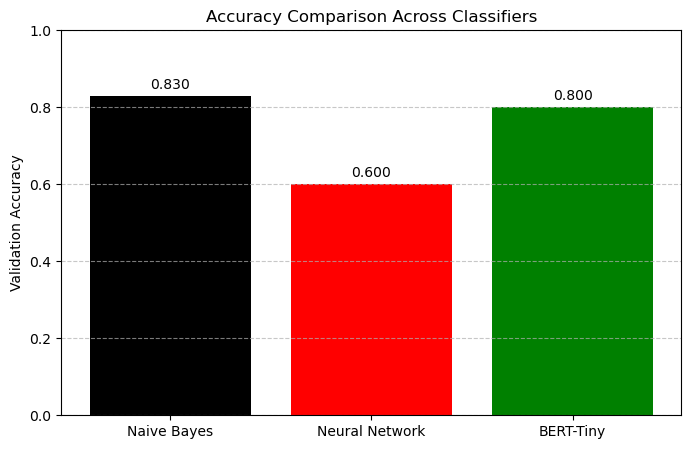

In [18]:
#Plotting the accuracies of the three models 
import matplotlib.pyplot as plt

model_names = ['Naive Bayes', 'Neural Network', 'BERT-Tiny']
model_accuracies = [accuracy_improved, accuracy_nn, accuracy_tinybert]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, model_accuracies, color=['black', 'red', 'green'])
plt.ylim(0, 1)
plt.title('Accuracy Comparison Across Classifiers')
plt.ylabel('Validation Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, acc in zip(bars, model_accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{acc:.3f}', ha='center', va='bottom')

plt.show()


In [19]:
import pandas as pd

model_names = ['Naive Bayes', 'Neural Network', 'BERT-Tiny']
model_accuracies = [accuracy_improved, accuracy_nn, accuracy_tinybert]
results_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": model_accuracies
})

print(results_df.to_string(index=False))


         Model  Accuracy
   Naive Bayes      0.83
Neural Network      0.60
     BERT-Tiny      0.80


In [20]:
# Extracting misclassified examples for Naive Bayes, Neural Network, and BERT-Tiny
print("\nMisclassified by Naive Bayes:")
for text, true, pred in zip(val_texts, val_labels, predictions_nb):
    if true != pred:
        print(f"[True: {true}] [Predicted: {pred}]\n{text}\n")
        break  


print("\nMisclassified by Neural Network:")
for text, true, pred in zip(val_texts, val_labels, predictions_nn):
    if true != pred:
        print(f"[True: {true}] [Predicted: {pred}]\n{text}\n")
        break

print("\nMisclassified by BERT-Tiny:")
for text, true, pred in zip(val_texts, val_labels, predictions_bert):
    if true != pred:
        print(f"[True: {true}] [Predicted: {pred}]\n{text}\n")
        break



Misclassified by Naive Bayes:
[True: 1] [Predicted: 2]
In addition, our NGESO published an update to their operability strategy showing the milestones to deliver zero carbon operation of the Great Britain Transmission network by 2025. See page 39.


Misclassified by Neural Network:
[True: 1] [Predicted: 0]
Environmental, Social, and Governance Evaluation In April 2019, Ratings launched a comprehensive Environmental, Social, and Governance Evaluation that enables companies to measure their long term preparedness to manage Environmental, Social, and Governance exposure and opportunities. The Environmental, Social, and Governance Evaluation combines quantitative and qualitative analysis and considers both near-term and longer-term Environmental, Social, and Governance risks and risk mitigants for the subject company/entity. Our criteria for evaluating Environmental, Social, and Governance risks will vary by issuer type depending on the issuer's sensitivities; corporate analysis considers